In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Goals
1. **Import Data**: Use `pd.read_csv('AM_April22_learning.csv')` to load the dataset.
2. **Calculate `p_correct`**: Compute the proportion of correct choices per session.
3. **Visualize Learning Over Time**: Plot `p_correct` across days.
4. **Analyze Effect of Delay**: Examine `p_correct` variation with different delay times.
5. **Calculate `d'` (d prime)**: Use hit rates and false positive rates for sensitivity analysis.
6. **Process `lick_data`**: Clean and structure nested numpy arrays from `lick_data` column.
7. **Visualize Lick Data**: Plot lick events over time per trial type.
8. **Document Findings**: Summarize methods, results, and insights.

## Data Loading

In [3]:
#df mouse learning the task I suppose
learning_df = pd.read_csv('/Users/chenx/Desktop/MacAskill Lab/Data/data_from_svenja/AM_April22_learning.csv',index_col=0)

#now we are changing the time in between the 2 odours and we want to see the key metrics have changed or not
diff_delay_df=pd.read_csv('/Users/chenx/Desktop/MacAskill Lab/Data/data_from_svenja/am_timing_data.csv',index_col=0)

In [4]:
# [x for x in diff_delay_df.lick_data.values].astype()

In [5]:
# type(diff_delay_df.lick_data[0][0])

In [6]:
proportions = diff_delay_df['delay'].value_counts(normalize=True)

In [7]:
diff_delay_df['trial_type'].value_counts(normalize=True)

trial_type
a->c    0.196381
b->c    0.195849
a->b    0.193365
c->b    0.150435
b->a    0.143516
c->a    0.120454
Name: proportion, dtype: float64

## Learning progress for each mouse across time

In [8]:
# Group the data by 'mouse' and 'day' to calculate the daily learning rate for each mouse then aggregiate to more concise information columns
daily_summary = learning_df.groupby(['mouse', 'day']).agg(
    total_trials=('correct', 'count'),
    total_correct=('correct', 'sum'),
    hits=('hit', 'sum'),
    correct_rejections=('correct_rejection', 'sum')
).reset_index()

# Calculate the learning rate as (hits + correct rejections) / total trials
daily_summary['learning_rate'] = (daily_summary['hits'] + daily_summary['correct_rejections']) / daily_summary['total_trials']

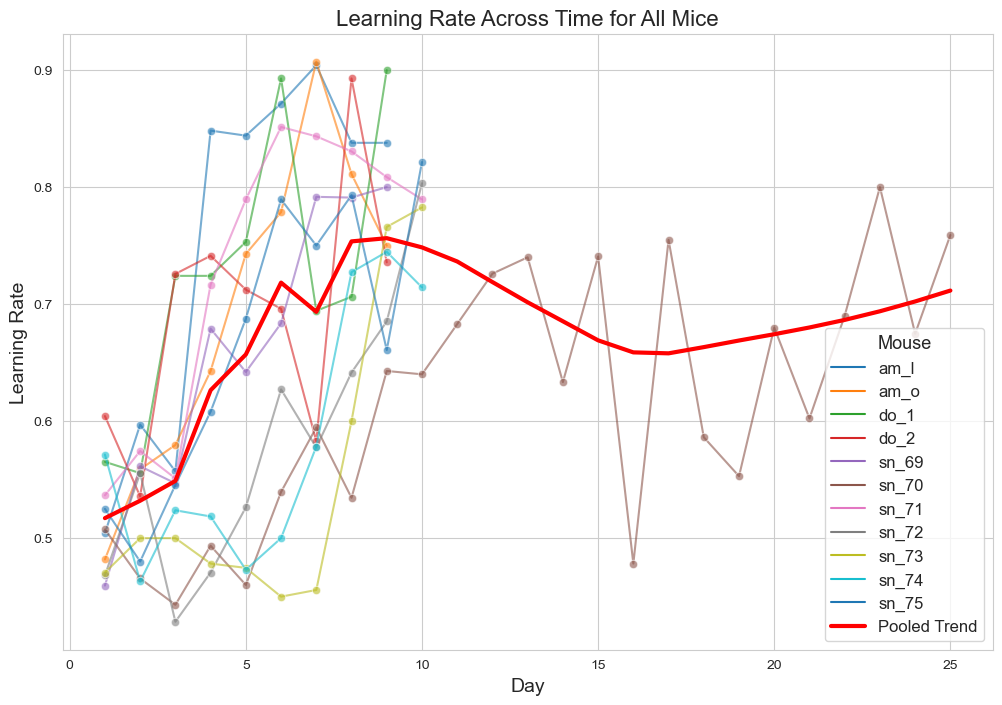

In [9]:
# Plot learning rate across time for all mice on a single plot
plt.figure(figsize=(12, 8))

# Use seaborn to plot with a different color for each mouse
sns.lineplot(data=daily_summary, x="day", y="learning_rate", hue="mouse", marker="o", linestyle="-", alpha = 0.6, palette="tab10")
# Calculate and plot a smoothed trend line for the pooled data using lowess
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
# Pooling all mice data together and applying lowess for a smoothed trend
pooled_lowess = lowess(daily_summary['learning_rate'], daily_summary['day'], frac=0.2)

# Plotting the smoothed trend line
plt.plot(pooled_lowess[:, 0], pooled_lowess[:, 1], color='red', lw=3, label='Pooled Trend')
plt.title('Learning Rate Across Time for All Mice', fontsize=16)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Learning Rate', fontsize=14)
plt.legend(title='Mouse', title_fontsize='13', fontsize='12')
plt.grid(True)

# Show the plot
plt.show()


In [14]:
# # Plot learning rate across time for each mouse
# g = sns.FacetGrid(daily_summary, col="mouse", col_wrap=4, height=4, sharey=True)
# g = g.map(plt.plot, "day", "learning_rate", marker="o", linestyle="-")
# g = g.map(plt.fill_between, "day", "learning_rate", alpha=0.2).set_titles("{col_name}")
# g.set_axis_labels("Day", "Learning Rate")
# g.fig.suptitle('Learning Rate Across Time for Each Mouse', fontsize=16, y=1.05)
# 
# # Show the plot
# plt.show()

## Learning rate for each mouse for different delay time

In [15]:
# Group the data by 'mouse' and 'day' to calculate the daily learning rate for each mouse then aggregiate to more concise information columns
daily_summary_diff_delay = diff_delay_df.groupby(['mouse', 'day','delay']).agg(
    total_trials=('correct', 'count'),
    total_correct=('correct', 'sum'),
    hits=('hit', 'sum'),
    correct_rejections=('correct_rejection', 'sum')
).reset_index()

# Calculate the learning rate as (hits + correct rejections) / total trials
daily_summary_diff_delay['learning_rate'] = (daily_summary_diff_delay['hits'] + daily_summary_diff_delay['correct_rejections']) / daily_summary_diff_delay['total_trials']

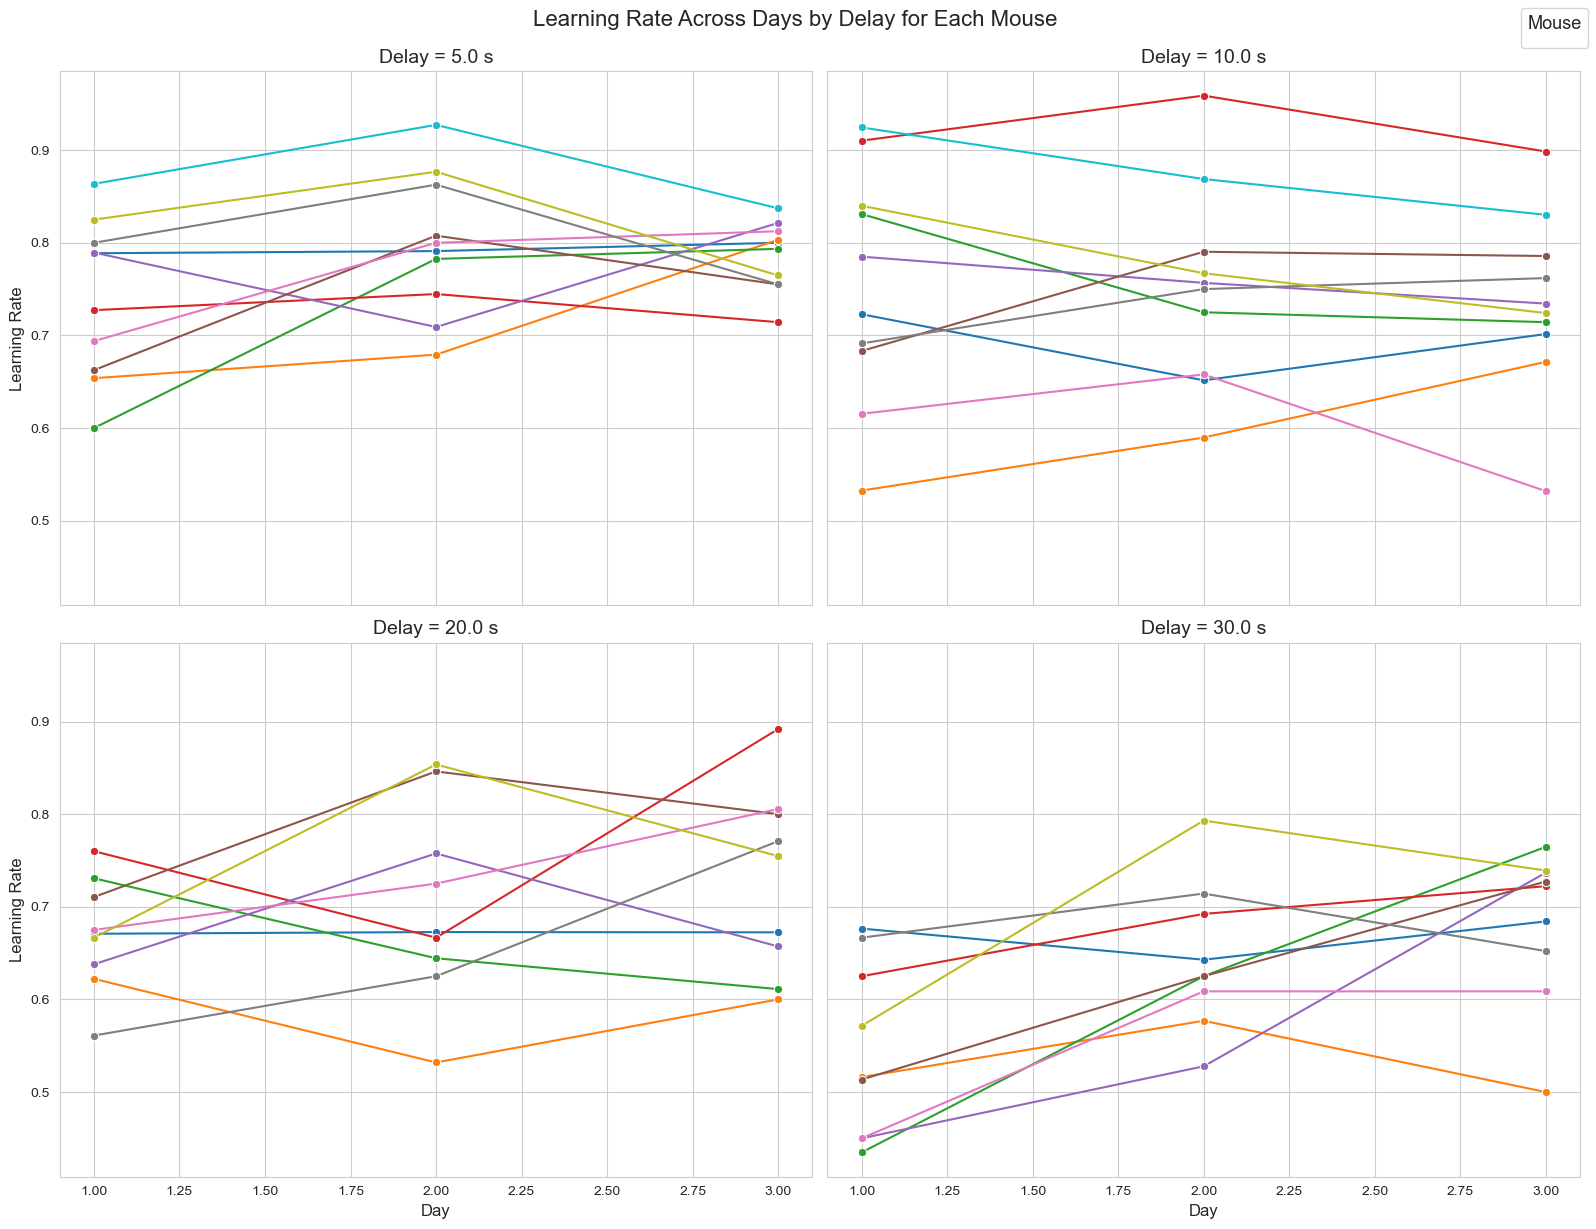

In [16]:
# Dynamically generate a color palette based on the number of unique mice
num_mice = len(daily_summary_diff_delay['mouse'].unique())
plot_colors = sns.color_palette("tab10", n_colors=num_mice)
unique_delays = daily_summary_diff_delay['delay'].unique()

# Display unique delay values
unique_delays

# Re-create the plots with the corrected color palette
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through each unique delay and create a plot
for i, delay in enumerate(sorted(unique_delays)):
    ax = axes[i]
    # Filter data for the current delay
    delay_data = daily_summary_diff_delay[daily_summary_diff_delay['delay'] == delay]
    # Plot learning rate for each mouse, adjusting for the correct number of colors
    sns.lineplot(ax=ax, data=delay_data, x='day', y='learning_rate', hue='mouse', marker="o", linestyle="-", legend=False)
    ax.set_title(f'Delay = {delay} s', fontsize=14)
    ax.set_xlabel('Day', fontsize=12)
    ax.set_ylabel('Learning Rate', fontsize=12)

# Adjust layout and titles
plt.tight_layout()
plt.suptitle('Learning Rate Across Days by Delay for Each Mouse', fontsize=16, y=1.02)

# Since the legend is the same for all plots, add it back manually after plotting
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Mouse', title_fontsize='13', fontsize='12')

plt.show()


### Cheking if the learning rates across different delays are stastically different. 
- Hypothesis: longer the delay, harder it is for mouse to learn, so lower the learning rate

In [17]:
# Re-import necessary libraries and re-load data due to execution environment reset
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load the dataset again
timing_data = diff_delay_df

# Aggregate data again for learning rate by mouse, day, and delay
daily_summary_diff_delay = timing_data.groupby(['mouse', 'day', 'delay']).agg(
    total_trials=('correct', 'count'),
    total_correct=('correct', 'sum'),
    hits=('hit', 'sum'),
    correct_rejections=('correct_rejection', 'sum')
).reset_index()

# Calculate the learning rate as (hits + correct rejections) / total trials
daily_summary_diff_delay['learning_rate'] = (daily_summary_diff_delay['hits'] + daily_summary_diff_delay['correct_rejections']) / daily_summary_diff_delay['total_trials']

# Now fit an ANOVA model to test for differences in learning rates across delays
model = ols('learning_rate ~ C(delay)', data=daily_summary_diff_delay).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

anova_results


,sum_sq,df,F,PR(>F)
C(delay),0.367040,3.0,13.936364,9.133855e-08
Residual,0.965685,110.0,NaN,NaN


In [18]:
daily_summary_diff_delay

,mouse,day,delay,total_trials,total_correct,hits,correct_rejections,learning_rate
0,sn_69,1,5.0,71,56.0,27.0,29.0,0.788732
1,sn_69,1,10.0,83,60.0,18.0,42.0,0.722892
2,sn_69,1,20.0,79,53.0,12.0,41.0,0.670886
3,sn_69,1,30.0,34,23.0,6.0,17.0,0.676471
4,sn_69,2,5.0,67,53.0,25.0,28.0,0.791045
...,...,...,...,...,...,...,...,...
109,sn_80,2,30.0,29,23.0,13.0,10.0,0.793103
110,sn_80,3,5.0,43,36.0,21.0,15.0,0.837209
111,sn_80,3,10.0,53,44.0,28.0,16.0,0.830189
112,sn_80,3,20.0,53,40.0,25.0,15.0,0.754717


In [19]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=daily_summary_diff_delay['learning_rate'], groups=daily_summary_diff_delay['delay'], alpha=0.05)

# Display the results
print(tukey_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   5.0   10.0  -0.0279  0.658  -0.091  0.0352  False
   5.0   20.0  -0.0739 0.0186 -0.1388 -0.0091   True
   5.0   30.0  -0.1509    0.0 -0.2157  -0.086   True
  10.0   20.0  -0.0461 0.2543 -0.1109  0.0188  False
  10.0   30.0   -0.123    0.0 -0.1878 -0.0581   True
  20.0   30.0  -0.0769 0.0166 -0.1434 -0.0104   True
----------------------------------------------------


### Results 

1. These results support the conclusion that longer delays affect learning rates significantly, particularly when comparing the shortest delay (5s) to the longest (30s), and even between intermediate delays (20s to 30s). 

2. The statistical significance indicates that the observed differences in learning rates are unlikely due to random chance, affirming the hypothesis that delay times can have a substantial impact on learning performance in these experiments.

3. This analysis provides valuable insights into how timing affects learning, which could have implications for understanding memory processes, attention, and decision-making strategies in the subjects of the study.


- This analysis suggests that as the delay increases, particularly from 5s to 30s, there is a significant impact on the learning rate, with longer delays generally associated with lower learning rates. This could indicate that tasks with longer delay times are more challenging, affecting the animals' ability to learn or recall the correct responses.

- Mean Differences: In addition to the test results, we looked at the "meandiff" column, which represents the mean difference in learning rates between each pair of delay groups. We observed that as the delay time increased, the mean difference became more negative. For example, the mean difference between 5s and 30s was more negative than between 5s and 20s, indicating a larger decrease in learning rates as the delay increased.





# Creating a strategy (underlying logistic regression) evolving diffusion visualization
# learning_df

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
import numpy as np

def scikit_log_reg_est(X, y):
    # Ensure X is a NumPy array for efficiency
    if not isinstance(X, np.ndarray):
        X = np.array(X)

    # If y is a pandas series, convert to numpy array
    if not isinstance(y, np.ndarray):
        y = y.to_numpy()

    param_range = np.arange(0.01, 10.1, 0.1)
    param_grid = [{'C': param_range}]

    # Initialize and fit GridSearchCV
    gs = GridSearchCV(estimator=linear_model.LogisticRegression(solver='saga', fit_intercept=False),
                      param_grid=param_grid, scoring='accuracy', cv=5)
    gs.fit(X, y)

    # Use the best estimator directly
    best_reg = gs.best_estimator_

    # Evaluate the model
    score = best_reg.score(X, y)
    return best_reg, score


In [2]:
data = pd.read_csv('data/AM_April22_learning.csv',index_col=0)
data

,trial_type,lick_data,go_nogo,outcome,correct,set,mouse,day,hit,miss,correct_rejection,false_positive
0,c->b,[0.002563 0.001273 0.002563 ... 0.002563 0.002...,no_go,correct_rejection,1.0,0.0,am_o,1,0.0,0.0,1.0,0.0
1,b->a,[0.002563 0.002563 0.002563 ... 0.002563 0.002...,no_go,false_positive,0.0,0.0,am_o,1,0.0,0.0,0.0,1.0
2,c->a,[0.002563 0.002563 0.002563 ... 0.002563 0.002...,go,miss,0.0,0.0,am_o,1,0.0,1.0,0.0,0.0
3,a->b,[0.002563 0.001273 0.002563 ... 0.002563 0.001...,go,miss,0.0,0.0,am_o,1,0.0,1.0,0.0,0.0
4,b->c,[0.001273 0.002563 0.002563 ... 0.002563 0.002...,go,correct,1.0,0.0,am_o,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
51,c->b,[0.001562 0.002849 0.001562 ... 0.001562 0.001...,no_go,correct_rejection,1.0,1.0,sn_75,10,0.0,0.0,1.0,0.0
52,b->c,[2.849000e-03 2.760000e-04 1.562000e-03 ... 4....,go,correct,1.0,1.0,sn_75,10,1.0,0.0,0.0,0.0
53,a->c,[0.001562 0.001562 0.001562 ... 0.000276 0.001...,no_go,correct_rejection,1.0,1.0,sn_75,10,0.0,0.0,1.0,0.0
54,a->b,[4.135000e-03 5.422000e-03 4.135000e-03 ... 4....,go,correct,1.0,1.0,sn_75,10,1.0,0.0,0.0,0.0


In [4]:
# Define day intervals for analysis, each representing a 5-day chunk
intervals = [(1, 5), (6, 10), (11, 15), (16, 20), (21, 25)]

rows_list = []  # Initialize an empty list to store row data

for start, end in intervals:
    interval_df = data[(data['day'] >= start) & (data['day'] <= end)]
    success_rate = interval_df['correct'].mean()  # Calculate average success rate for the interval

    # For strategy analysis: Count occurrences of each trial type
    trial_type_counts = interval_df['trial_type'].value_counts().to_dict()

    # Create a dict for the current row and append it to the rows list
    rows_list.append({
        'Interval': f"{start}-{end}",
        'Average_Success_Rate': success_rate,
        **trial_type_counts
    })

# Convert the list of dicts to a DataFrame
analysis_results = pd.DataFrame(rows_list)

# Proceed with your subsequent DataFrame processing
analysis_results = analysis_results.fillna(0)  # Fill NaN values with 0 for counts
columns_order = ['Interval', 'Average_Success_Rate'] + sorted(list(set(data['trial_type'])))
analysis_results = analysis_results[columns_order]

print(analysis_results)


  Interval  Average_Success_Rate  a->b  a->c  b->a  b->c  c->a  c->b
0      1-5              0.602887   915  1073   700   942   543   677
1     6-10              0.738829   897  1059   699  1028   453   631
2    11-15              0.702194    66   101    32    78     5    37
3    16-20              0.608173    93   121    49    91    16    46
4    21-25              0.701266    98   133    30   102     4    28


In [8]:
def make_matrix (task_data, subject, session):
#choose subset of task data for mouse and session
    GLM_data = task_data[(task_data.mouse == subject) & (task_data.day == session)]
    GLM_data = GLM_data.reset_index()
    
    #empty matrix with 15 columns
    GLM_matrix = pd.DataFrame(columns = ['lick','A', 'B', 'C', 'AandB', 'AandC','CandB', 'AB', 'BA', 'AC', 'CA', 'BC', 'CB', 'previous_reward', 'previous_choice'])
    reward = 0 #will change every loop iteration and store reward on previous trial (1 = R, 0 = none)
    choice = 0 #will change every loop iteration and store choice on previous trial (1 = lick, -1 = no lick)
    
    #For each trial in the session
    for index, row in GLM_data.iterrows():
        #make empty array with 15 columns
        temp = np.zeros(15, dtype = int)
    
        #Record stimulus order 
        if (row['trial_type'] == 'a->b'):
            temp[1] = 1  #A
            temp[2] = 1  #B
            temp[3] = 0  #C
            temp[4] = 1  #AandB
            temp[5] = 0  #AandC
            temp[6] = 0  #CandB
            temp[7] = 1  #AB
            temp[8] = 0  #BA
            temp[9] = 0  #AC
            temp[10] = 0 #CA
            temp[11] = 0 #BC
            temp[12] = 0 #CB
        if (row['trial_type'] == 'b->a'):
            temp[1] = 1  #A
            temp[2] = 1  #B
            temp[3] = 0  #C
            temp[4] = 1  #AandB
            temp[5] = 0  #AandC
            temp[6] = 0  #CandB
            temp[7] = 0  #AB
            temp[8] = 1  #BA
            temp[9] = 0  #AC
            temp[10] = 0 #CA
            temp[11] = 0 #BC
            temp[12] = 0 #CB
        if (row['trial_type'] == 'a->c'):
            temp[1] = 1  #A
            temp[2] = 0  #B
            temp[3] = 1  #C
            temp[4] = 0  #AandB
            temp[5] = 1  #AandC
            temp[6] = 0  #CandB
            temp[7] = 0  #AB
            temp[8] = 0  #BA
            temp[9] = 1  #AC
            temp[10] = 0 #CA
            temp[11] = 0 #BC
            temp[12] = 0 #CB
        if (row['trial_type'] == 'c->a'):
            temp[1] = 1  #A
            temp[2] = 0  #B
            temp[3] = 1  #C
            temp[4] = 0  #AandB
            temp[5] = 1  #AandC
            temp[6] = 0  #CandB
            temp[7] = 0  #AB
            temp[8] = 0  #BA
            temp[9] = 0  #AC
            temp[10] = 1 #CA
            temp[11] = 0 #BC
            temp[12] = 0 #CB
        if (row['trial_type'] == 'b->c'):
            temp[1] = 0  #A
            temp[2] = 1  #B
            temp[3] = 1  #C
            temp[4] = 0  #AandB
            temp[5] = 0  #AandC
            temp[6] = 1  #CandB
            temp[7] = 0  #AB
            temp[8] = 0  #BA
            temp[9] = 0  #AC
            temp[10] = 0 #CA
            temp[11] = 1 #BC
            temp[12] = 0 #CB
        if (row['trial_type'] == 'c->b'):
            temp[1] = 0  #A
            temp[2] = 1  #B
            temp[3] = 1  #C
            temp[4] = 0  #AandB
            temp[5] = 0  #AandC
            temp[6] = 1  #CandB
            temp[7] = 0  #AB
            temp[8] = 0  #BA
            temp[9] = 0  #AC
            temp[10] = 0 #CA
            temp[11] = 0 #BC
            temp[12] = 1 #CB
    
    
        #If this is not the first trial, record previous choice and reward
        if(index > 0):
            temp[13] = reward
            temp[14] = choice
    
        if (row['hit'] > 0):
            temp[0] = 1
            reward = 1
            choice = 1
        if (row['false_positive'] > 0):
            temp[0] = 1
            reward = 0
            choice = 1
        if (row['miss'] > 0):
            temp[0] = 0
            reward = 1
            choice = 0
        if (row['correct_rejection'] > 0):
            temp[0] = 0
            reward = 0
            choice = 0
    
    
        new_row = {'lick':temp[0], 'A':temp[1], 'B':temp[2], 'C':temp[3], 'AandB':temp[4], 'AandC':temp[5], 'CandB':temp[6], 'AB':temp[7], 'BA':temp[8], 'AC':temp[9], 'CA':temp[10], 'BC':temp[11], 'CB':temp[12], 'previous_reward':temp[13], 'previous_choice':temp[14]}
        #append row to the dataframe
        GLM_matrix = GLM_matrix.append(new_row, ignore_index=True)
    
        return GLM_matrix

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

def train_logistic_regression_models(task_data, subject, session, bins):
    # Step 1: Preprocess data using the provided make_matrix function
    GLM_matrix = make_matrix(task_data, subject, session)

    # Convert to appropriate types
    GLM_matrix = GLM_matrix.astype({'lick': 'int', 'previous_choice': 'int', 'previous_reward': 'int'})

    # Step 2: Split data into bins (example: based on index)
    bin_size = len(GLM_matrix) // bins
    models = []

    for bin_start in range(0, len(GLM_matrix), bin_size):
        bin_end = bin_start + bin_size
        bin_data = GLM_matrix.iloc[bin_start:bin_end]

        # Separate features and target variable
        X = bin_data.drop('lick', axis=1)
        y = bin_data['lick']

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Step 3: Train logistic regression model with varying parameters
        # Example: Use GridSearchCV to find the best model parameters
        parameters = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
        lr = LogisticRegression(solver='liblinear')
        clf = GridSearchCV(lr, parameters, cv=5)
        clf.fit(X_train, y_train)

        # Evaluate model
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f'Bin {bin_start}-{bin_end}: Best Params: {clf.best_params_}, Accuracy: {accuracy}')

        models.append(clf)

    return models